# Reverse Engineering 1D Cellular Automata Rules
#### Author: Fiyinfoluwa Dideoluwa

This project explores Elementary Cellular Automata (ECA) simple 1D systems where each cell evolves over time based on a local 3-cell neighborhood and a deterministic rule (0-255). The goal includes:

1. Simulate and analyze the behavior of all 256 ECA rules.

2. Reverse engineer the rule number from a given CA grid by observing how states change over time.

### Steps

- Creating CA simulations using user-defined or random initial states.

- Measuring the frequency of active cells (1s) and clustering rules based on this behavior.

- Visualizing the spatial-temporal evolution of different rules.

- Implementing a rule inference algorithm that reconstructs the original CA rule from the generated grid, validating its accuracy and robustness across multiple rule types.

#### Import Required Libraries

In [13]:
# Numerical & Data Handling
import numpy as np                    
import pandas as pd                 

# Visualization
import matplotlib.pyplot as plt                        
from tabulate import tabulate          

# Machine Learning & Analysis  
from sklearn.cluster import KMeans                            
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances 
from sklearn.decomposition import PCA                     

# Math
from sympy.abc import epsilon         

# Project Utility Files
from plot_utils import plot_pca_scatter, plot_frequency_vector   
from my_utils import group_duplicates, create_summary_table

#### Define Helper Functions

In [14]:
def get_rule_table(rule_number):
    """
    Given a rule number (0–255), return a dictionary mapping each 3-bit neighborhood
    pattern (as string) to its binary outcome according to that rule.
    """
    binary_repr = f"{rule_number:08b}"  # convert rule number to 8-bit binary string (e.g 30 is converted to 00011110)
    keys = ['111', '110', '101', '100', '011', '010', '001', '000']  # These are all the possible 3-bit patterns in the order of most to least significant (as per Wolfram’s convention).
    return {k: int(b) for k, b in zip(keys, binary_repr)} # map each pattern to each binary output and return the dictionary


In [15]:
def run_ca(rule_number, grid_size, time_steps, init_mode):
    """
    Simulate a 1D cellular automaton (CA) for a given rule number.
    Parameters:
        rule_number: int, the CA rule (0–255)
        grid_size: number of cells per row
        time_steps: number of time steps to simulate
        init_mode: 'random' or 'single' to set initial state
    """
    # get corresponding rule table for a given rule number
    rule = get_rule_table(rule_number)
    # create empty grid and initialize with zeros
    grid = np.zeros((time_steps, grid_size), dtype=int)

    
    # Initialize the first row of the cellular automaton grid
    if isinstance(init_mode, str):  # If the user passed a string for init_mode
        if init_mode == 'single':
            # Set only the center cell in the first row to 1, rest remain 0
            grid[0, grid_size // 2] = 1
        elif init_mode == 'random':
            # Randomly assign each cell in the first row a value of 0 or 1
            grid[0] = np.random.choice([0, 1], size=grid_size)
        else:
            # The string is not recognized
            raise ValueError("Invalid init_mode string. Use 'single', 'random', or provide a custom array.")
    
    # If the user initializes a custom 1D CA array
    elif isinstance(init_mode, (list, np.ndarray)):
        # Convert the input to a NumPy array of integers (0s and 1s)
        custom_init = np.array(init_mode, dtype=int)
        
        # Check that the custom pattern is exactly the same length as the grid width
        if custom_init.shape[0] != grid_size:
            raise ValueError(f"Custom initial state must have length {grid_size}.")
        
        # Assign the custom pattern as the first row of the grid
        grid[0] = custom_init
    
    else:
        # If init_mode is neither a recognized string nor an array-like input
        raise TypeError("init_mode must be a string ('single' or 'random') or a 1D array-like object.")

    
    # Evolve the CA over time
    for t in range(1, time_steps):  # t goes from 1 to time_steps-1 (since row 0 is initialized already).
        for i in range(1, grid_size - 1):  # For each cell i (excluding the boundary cells i.e. first and last cells)
            neighborhood = ''.join(map(str, grid[t-1, i-1:i+2])) #join the 3-bit neighborhood patterns using stride = 1) from the previous grid
            grid[t, i] = rule[neighborhood]  # looks up the next state of the centre of the neighborhood from its rule and stores the new value in the next grid, t.
    return grid

In [16]:
def get_frequency_vector(grid):
    """
    Compute the frequency vector of 1s for a CA grid by averaging over time.
    Returns:
        1D NumPy array of frequencies for each cell.
    """
    return np.mean(grid, axis=0)

In [17]:
def find_neighbors(vectors, epsilon):
    """
    Compute Euclidean distance neighbors between all pairs of vectors.
    A neighbor is any other vector whose distance <= epsilon.
    Returns:=
        Dictionary mapping each index to a set of neighbor indices.
    """
    distances = pairwise_distances(vectors, metric="euclidean")
    
    neighbors = {}
    for i in range(len(distances)):
        neighbors[i] = set(np.where(distances[i] <= epsilon)[0]) - {i} # neighbors excluding self
    return neighbors


In [18]:
def check_symmetric_relations(neighbors):
    """
    	Verify whether the neighborhood relation is symmetric in the following way:
            if rule j is close to i, then
            set(i) ∪ {i} = set(j) ∪ {j}.

        Returns:
            (symmetric: bool, asym_pairs: list of asymmetric pairs)
    """
    symmetric = True   # Assume symmetry holds until proven otherwise
    asym_pairs = []    # List to collect asymmetric (i, j) pairs

    # Iterate through each rule (i) and its neighborhood (neigh_i)
    for i, neigh_i in neighbors.items():
        # Check each neighbor j of rule i
        for j in neigh_i:
            # Include i in its neighborhood
            set_i = neigh_i | {i}

            # Include j in its own neighborhood
            set_j = neighbors[j] | {j}

            # If neighborhoods differ, symmetry is violated
            if set_i != set_j:
                symmetric = False
                asym_pairs.append((i, j))  # Record the asymmetric pair

    # Return whether the relation is symmetric, and the list of violations (asymmetric pairs)
    return symmetric, asym_pairs

In [19]:
def generate_frequency_vectors(init_state, grid_size=20, time_steps=20):
    """Generate frequency vectors for all 256 rules."""
    vectors = []
    for rule_num in range(256):
        grid = run_ca(rule_num, grid_size=grid_size, time_steps=time_steps, init_mode=init_state)
        vectors.append(get_frequency_vector(grid))
    return np.array(vectors)  # Shape: (256, grid_size)

In [20]:
def cluster_and_plot(frequency_vectors, n_clusters=4):
    """Cluster frequency vectors using KMeans, reduce with PCA, and plot."""
    
    # Initialize KMeans with specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    # Fit KMeans to the data and predict the cluster labels
    labels = kmeans.fit_predict(frequency_vectors)

    # Apply PCA to reduce dimensionality of frequency vectors to 2D for clearer visualization
    reduced = PCA(n_components=2).fit_transform(frequency_vectors)

    # Plot the scatter diagram of the 2D PCA projection 
    plot_pca_scatter(reduced, labels)

    # Return the cluster labels for further analysis
    return labels

In [21]:

def analyze_symmetry(frequency_vectors, epsilon=None, verbose=True):
    """
        Computes pairwise distances between all frequency vectors,
        determines neighborhoods based on a distance threshold (epsilon), and
        checks whether the neighborhood relation is symmetric.
    """
    
     # Compute pairwise Euclidean distances between all frequency vectors
    distances = pairwise_distances(frequency_vectors, metric="euclidean")

    # If epsilon not provided, set it to the maximum distance observed
    if epsilon is None:
        epsilon = np.max(distances)

    # Find neighbors for each frequency vector based on epsilon value
    neighbors = find_neighbors(frequency_vectors, epsilon)

    # Check whether neighbor relations are symmetric
    symmetric, asym_pairs = check_symmetric_relations(neighbors)

    # Print results for inspection
    if verbose:
        if symmetric:
            print(f"All neighbor sets are symmetric (epsilon={epsilon})")
        else:
            print(f"Found {len(asym_pairs)} asymmetric pairs (epsilon={epsilon})")

    # Return results
    return symmetric, asym_pairs, epsilon

In [22]:
def process_initial_state(initial_state, n_clusters=4, n_steps=20, epsilon=None, verbose=True):
    """
    Run the full pipeline: Cellular Automaton (CA) simulation -> 
    frequency vector extraction -> clustering -> symmetry analysis.
    """
     
    # Generate frequency vectors from all 256 rules on the provided initial state,
    freq_vectors = generate_frequency_vectors(initial_state, time_steps=n_steps)

    # Cluster the frequency vectors and plot them using PCA projection.
    labels = cluster_and_plot(freq_vectors, n_clusters)

    # Analyze whether neighbor relations among frequency vectors are symmetric.
    symmetric, asym_pairs, epsilon = analyze_symmetry(
        freq_vectors, epsilon, verbose=verbose
    )

    # Return the full set of results
    return freq_vectors, labels, symmetric, asym_pairs, epsilon

In [23]:
def plot_distance_histogram(freq_vectors, title):
    """Plot histogram of all pairwise Euclidean distances between frequency vectors."""
    
    # Compute pairwise Euclidean distances between all frequency vectors
    distances = pairwise_distances(freq_vectors, metric="euclidean")
    
    # Plot Histogram
    plt.figure(figsize=(8,6))
    plt.hist(distances.flatten(), bins=50)
    plt.title(title)
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


#### Full CA Pipeline Execution


=== Processing Initial State 1 ===


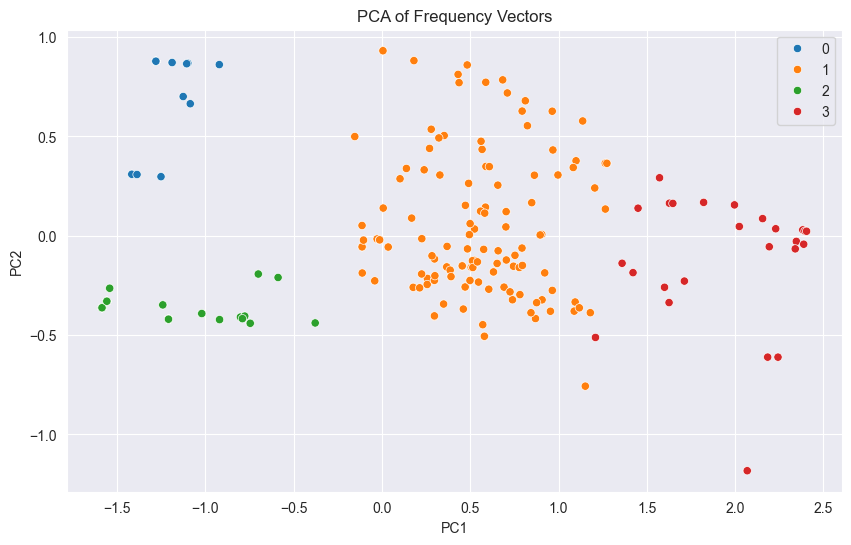

All neighbor sets are symmetric (epsilon=0)

=== Processing Initial State 2 ===


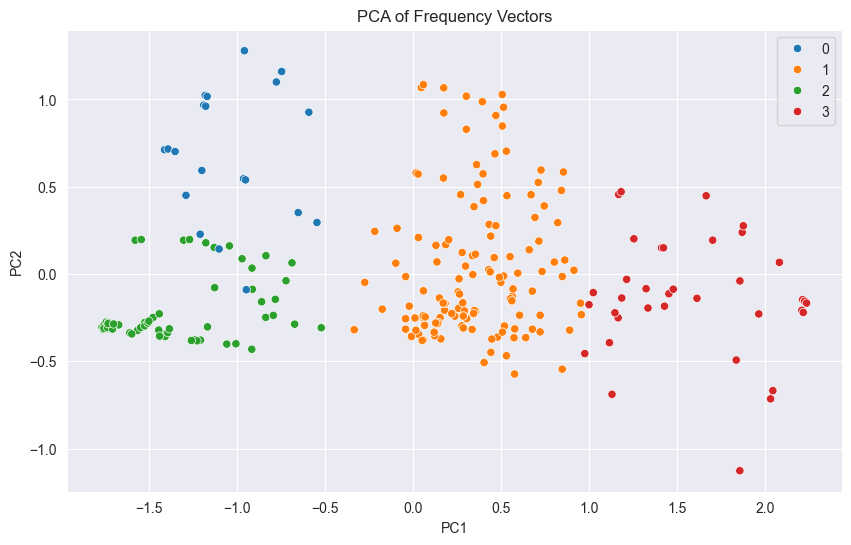

All neighbor sets are symmetric (epsilon=0)

=== Processing Initial State 3 ===


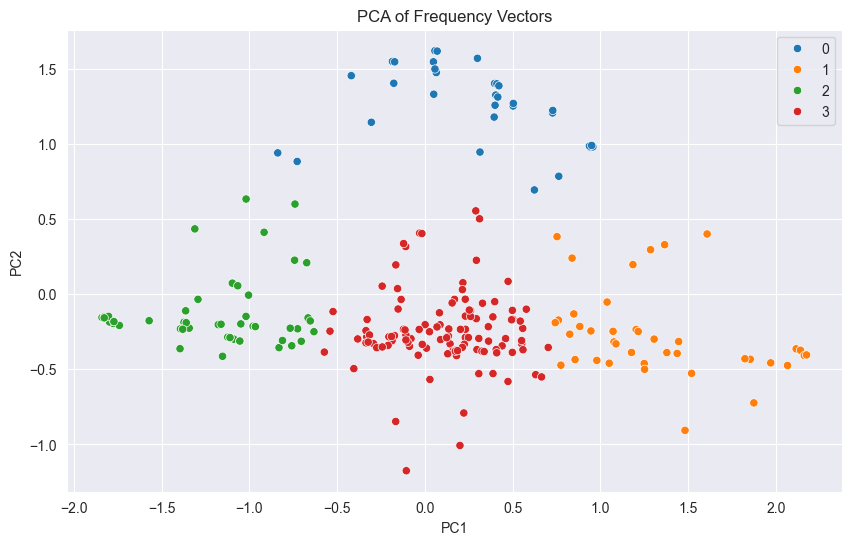

All neighbor sets are symmetric (epsilon=0)

=== Duplicate Frequency Vector Statistics ===
          Initial State  Group Count  \
0  01001000000000000000           34   
1  01011100000000000010            2   
2  01001001010100010111           22   

                                    Duplicate Groups  
0  [[1, 9, 33, 41, 65, 73, 97, 105, 129, 137, 161...  
1                            [[59, 187], [115, 243]]  
2  [[1, 65], [3, 67], [5, 69], [9, 73], [11, 75],...  


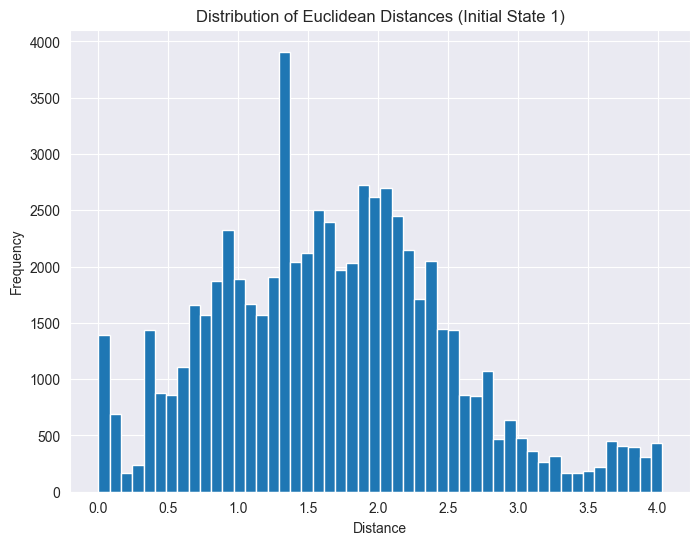

In [24]:
# Define a list of custom initial states
init_states = [
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
     0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
     0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
]

all_results = [] # Stores results of processing each initial state
epsilon_value = 0  # Define epsilon value

# Loop through each initial state and process it
for idx, init in enumerate(init_states, start=1):
    print(f"\n Processing Initial State {idx} ...")

    # Run full pipeline: CA -> frequency vectors -> clustering -> symmetry analysis
    freq_vectors, labels, symmetric, asym_pairs, epsilon = process_initial_state(
        init, n_clusters=4, n_steps=20, epsilon=epsilon_value, verbose=True
    )

    # Store results in a dictionary 
    all_results.append({
        "init_state_index": idx,
        "frequency_vectors": freq_vectors,
        "labels": labels,
        "symmetric": symmetric,
        "asymmetric_pairs": asym_pairs,
        "epsilon": epsilon
    })

# Create a summary DataFrame with duplicate statistics
df = create_summary_table(init_states, all_results)

# Save summary results to CSV for external analysis
df.to_csv("duplicate_stats.csv", index=False)

# Print summary table in the console for quick inspection
print("\n Duplicate Frequency Vector Statistics ")
print(df)

# Plot distance distribution for the first initial state for insight
plot_distance_histogram(
    all_results[0]["frequency_vectors"], 
    "Distribution of Euclidean Distances (Initial State 1)"
)


#### Identify CA rules that consistently belong to the same cluster across multiple initial states.


In [25]:

def check_cluster_consistency(all_results, verbose=True):
    """
    Check how consistently each CA rule is assigned to the same cluster
    across multiple runs with different initial states.
    """
    
    # List to store the number of unique clusters each rule appears in
    consistency_counts = []

    # List to store indices of rules that appear in more than one cluster
    unstable_rules = []

    # Dictionary mapping each rule index to the set of clusters it was assigned to
    rule_cluster_map = {}

    # Loop over all 256 CA rules
    for rule_idx in range(256):
        # Collect the cluster label assigned to this rule in each initial state
        labels_per_state = [result["labels"][rule_idx] for result in all_results]

        # Get the unique cluster labels for this rule across all initial states
        unique_labels = set(labels_per_state)

        # Record how many different clusters this rule appeared in
        consistency_counts.append(len(unique_labels))

        # Store the mapping of rule to all cluster IDs it appeared in
        rule_cluster_map[rule_idx] = unique_labels

        # If the rule appeared in more than one cluster, it's unstable
        if len(unique_labels) > 1:
            unstable_rules.append(rule_idx)

    # Print summary
    if verbose:
        print("\nCluster Consistency Summary:")
        print(f"Mean number of unique labels per rule: {np.mean(consistency_counts):.2f}")
        print(f"Rules always in the same cluster: {sum(c == 1 for c in consistency_counts)} / 256")
        print("\nUnstable rules (assigned to >1 cluster):", unstable_rules)

    # Return the detailed results 
    return consistency_counts, unstable_rules, rule_cluster_map


#### Print the Cluster consistency for a particular Rule 


Cluster Consistency Summary:
Mean number of unique labels per rule: 1.75
Rules always in the same cluster: 73 / 256

Unstable rules (assigned to >1 cluster): [1, 3, 5, 6, 7, 9, 11, 13, 14, 15, 17, 19, 21, 22, 23, 25, 27, 28, 29, 30, 31, 33, 35, 36, 37, 39, 41, 43, 45, 46, 47, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 67, 69, 70, 71, 73, 75, 77, 78, 79, 81, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 95, 97, 99, 100, 101, 102, 103, 105, 106, 107, 109, 110, 113, 114, 115, 117, 118, 119, 121, 122, 123, 124, 126, 127, 129, 131, 133, 134, 135, 137, 139, 141, 142, 143, 145, 147, 149, 150, 151, 153, 154, 155, 156, 157, 159, 161, 163, 164, 165, 166, 167, 169, 171, 173, 174, 175, 177, 178, 179, 181, 183, 185, 186, 187, 189, 191, 193, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 211, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255]

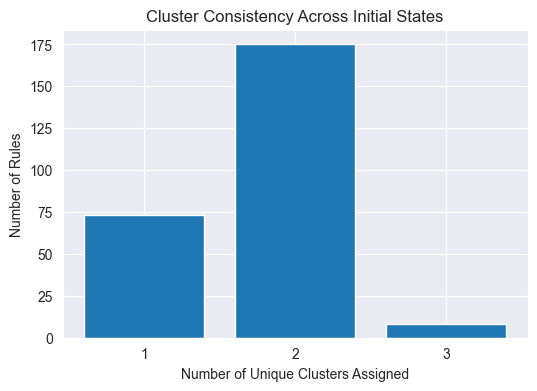

In [32]:
# Example: Check which clusters rule 30 was assigned to across all initial states
consistency_counts, unstable_rules, rule_cluster_map = check_cluster_consistency(all_results)
print(f"\nRule 30 appeared in clusters: {set(int(x) for x in rule_cluster_map[30])}")



# Histogram visualization of Cluster consistency
plt.figure(figsize=(6,4))
plt.hist(consistency_counts, bins=[0.5,1.5,2.5,3.5], rwidth=0.8)
plt.xticks([1,2,3])
plt.xlabel("Number of Unique Clusters Assigned")
plt.ylabel("Number of Rules")
plt.title("Cluster Consistency Across Initial States")
plt.grid(True)
plt.show()


#### Run the full Pipeline for a number of Random Initial States

In [27]:
num_random_states = 500    # Number of random initial states to generate
grid_size = 20             # Number of cells in each CA row

# Generate random initial states (each with a random array of 0s and 1s)
random_initial_states = [
    np.random.choice([0,1], size=grid_size)
    for _ in range(num_random_states)
]

# Parameters
n_clusters = 4  # Number of clusters for KMeans
epsilon = epsilon

# Initialize an array to store labels for each rule and each initial state
all_labels_matrix = np.zeros((256, num_random_states), dtype=int)

print(f"\nProcessing {num_random_states} random initial states...")

# Loop over each random initial state
for idx, init_state in enumerate(random_initial_states):
    frequency_vectors = []
    # For each of the 256 elementary CA rules:
    for rule_num in range(256):
        # Simulate the CA with this initial state
        grid = run_ca(rule_num, grid_size=grid_size, time_steps=200, init_mode=init_state)
        
        # Compute the mean frequency vector (averaged over time steps) and store it
        freq_vector = get_frequency_vector(grid)
        frequency_vectors.append(freq_vector)

    frequency_vectors = np.array(frequency_vectors)  # Convert to numpy array

    # Cluster the frequency vectors into clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(frequency_vectors)

    # Store labels for this initial state
    all_labels_matrix[:, idx] = labels

    # Print progress at every 50 iterations
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1} / {num_random_states} initial states.")

print("Done.")



Processing 500 random initial states...
Processed 50 / 500 initial states.
Processed 100 / 500 initial states.
Processed 150 / 500 initial states.
Processed 200 / 500 initial states.
Processed 250 / 500 initial states.
Processed 300 / 500 initial states.
Processed 350 / 500 initial states.
Processed 400 / 500 initial states.
Processed 450 / 500 initial states.
Processed 500 / 500 initial states.
Done.


In [28]:
# Compute unique label counts per rule
consistency_counts = []
for rule_idx in range(256):
    unique_labels = set(all_labels_matrix[rule_idx, :])
    consistency_counts.append(len(unique_labels))


In [29]:
# Print summary statistics
print(f"\nCluster Consistency Over {num_random_states} Random Initial States")
print(f"Mean number of unique labels per rule: {np.mean(consistency_counts):.2f}")
print(f"Rules always assigned to the same cluster: {sum(c==1 for c in consistency_counts)} / 256")
print(f"Rules assigned to 2 clusters: {sum(c==2 for c in consistency_counts)}")
print(f"Rules assigned to 3 clusters: {sum(c==3 for c in consistency_counts)}")
print(f"Rules assigned to all 4 clusters: {sum(c==4 for c in consistency_counts)}")



 Cluster Consistency Over 500 Random Initial States
Mean number of unique labels per rule: 3.96
Rules always assigned to the same cluster: 0 / 256
Rules assigned to 2 clusters: 0
Rules assigned to 3 clusters: 9
Rules assigned to all 4 clusters: 247


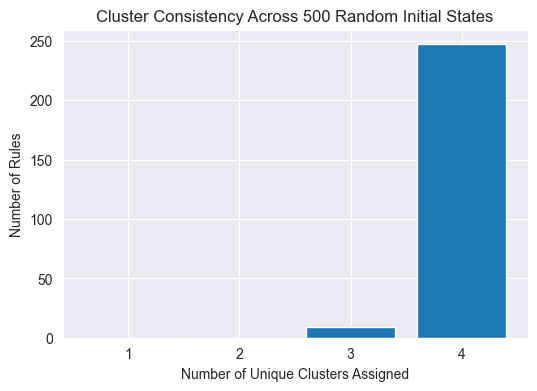

In [30]:
# Histogram visualization of Cluster consistency 
plt.figure(figsize=(6,4))
plt.hist(consistency_counts, bins=[0.5,1.5,2.5,3.5,4.5], rwidth=0.8)
plt.xticks([1,2,3,4])
plt.xlabel("Number of Unique Clusters Assigned")
plt.ylabel("Number of Rules")
plt.title("Cluster Consistency Across 500 Random Initial States")
plt.grid(True)
plt.show()
